In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import colors
plt.style.use('homework')

# Fitting

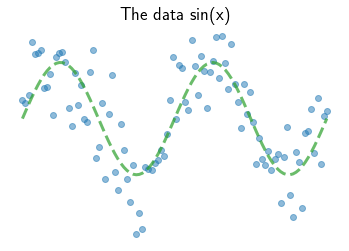

In [51]:
N = 100
freq = 1
periods = 2
coef = freq * 2 *np.pi
x = np.linspace(-periods/2, periods/2, N)
sine = np.sin(coef * x)
nonlin = np.sin(coef * x) + np.random.normal(scale=.5, size=N)

plt.plot(x, nonlin, 'o', alpha=0.5)
plt.plot(x, sine, lw=3, color='C2', ls='dashed', alpha=0.7)
plt.title(f"The data sin(x)")
plt.axis('off');

In [42]:
class PiecewiseModel:

    def __init__(self, x, data, k, y_actual, type='linear', plot=False):
        self.type = type
        self.regions = np.linspace(x.min(), x.max(), k+2)
        self.knots = [np.abs(x - xi).argmin() for xi in self.regions[1:-1]]
        self.k = k
        
        if type == 'linear':
            self.basis = self.piecewise_linear(x, k)
        elif type == 'cubic':
            self.basis = self.cubic_spline(x, k)
        else:
            raise Exception(f"type {type} not implemented")

        self.fit_predict(data)
        if plot:
            self.plot(x, data, y_actual)


    def fit_predict(self, data):
        """Least squares regression fit"""
        xstar, _, _, _ = np.linalg.lstsq(self.basis, data, rcond=None)
        self.xstar = xstar
        self.y_pred = self.basis @ self.xstar


    def piecewise_linear(self, x, k):
        basis = np.zeros((x.shape[0], k+2))
        basis[:,0] = 1
        basis[:,1] = x

        for i in range(1, k+1):
            activation = x - self.regions[i]
            basis[:, i+1] = np.where(activation > 0, activation, 0)
        return basis
    
    
    def cubic_spline(self, x, k):
        M = 4  # cubic polynomial order
        basis = np.zeros((x.shape[0], k + M))
        for i in range(M):
            basis[:,i] = np.power(x, i)
        for i in range(k):
            coef = x - self.regions[i+1]
            basis[:, M+i] = np.power(np.where(coef > 0, coef, 0), M-1)
        
        return basis


    def loss(self, y_actual, type='mse'):
        if type == 'mse':
            return ((y_actual - self.y_pred)**2).mean()
        elif type == 'mae':
            return ((y_actual - self.y_pred)**2).mean()
        else:
            raise Exception(f"Loss type {type} not implemented")


    def plot(self, x, data, y_actual):
        fig, ax = plt.subplots()
        ax.plot(x, data, '.', alpha=0.5)
        ax.plot(x, self.y_pred, lw=3)
        ax.plot(x[self.knots], self.y_pred[self.knots], 'ko')
        ax.plot(x, y_actual, '--', alpha=1, )
        if self.type == 'linear':
            pre = "Piecewise linear "
        elif self.type == 'cubic':
            pre = "Cubic spline "
        ax.set_title(pre + f"fit k={self.k} knots")
        ax.axis('off')

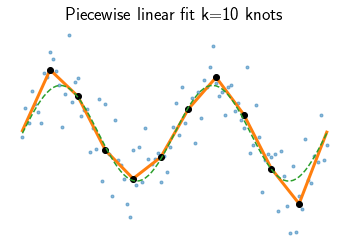

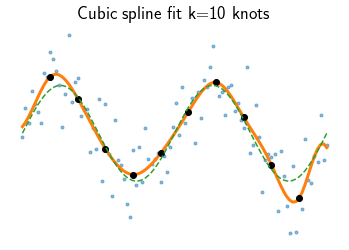

In [47]:
k = 10
linear = PiecewiseModel(x, nonlin, k, sine, plot=True)
spline = PiecewiseModel(x, nonlin, k, sine, "cubic", plot=True)

In [44]:
mse_pw = []
mse_spline = []
folds = np.arange(1, N//3 + 1)
for k in folds:
    linear = PiecewiseModel(x, nonlin, k, sine)
    spline = PiecewiseModel(x, nonlin, k, sine, "cubic")
    mse = linear.loss(sine)
    mse_pw.append(mse)
    mse = spline.loss(sine)
    mse_spline.append(mse)

mse_pw = np.array(mse_pw)
mse_spline = np.array(mse_spline)

Piecewise k*=13
Cubic Spline k*=5


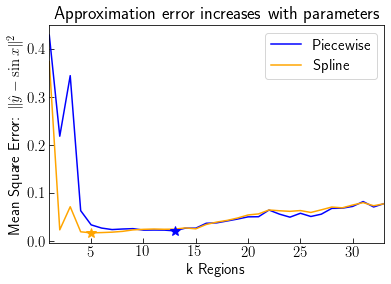

In [45]:
k_pw = mse_pw.argmin()
k_spline = mse_spline.argmin()
print(f"Piecewise k*={k_pw+1}\nCubic Spline k*={k_spline+1}")

plt.plot(folds, mse_pw, label="Piecewise", color='blue')
plt.plot(folds, mse_spline, label="Spline", color='orange')

plt.plot(k_pw+1, mse_pw[k_pw], '*', markersize=10, color='blue')
plt.plot(k_spline+1, mse_spline[k_spline], '*', markersize=10, color='orange')

# plt.scale('log')
plt.legend()
plt.xlim(1, folds.max())
plt.xlabel('k Regions')
plt.ylabel(r'Mean Square Error: $\| \hat y - \sin x \|^2$')
plt.title("Approximation error increases with parameters");

In [216]:
mse_spline

array([0.37537563, 0.02489018, 0.07182602, 0.01599253, 0.01761221,
       0.01737453, 0.01561466, 0.02001478, 0.02174126, 0.02005905,
       0.02054221, 0.02445234, 0.02888311, 0.0297037 , 0.02848578,
       0.02981139, 0.03782896, 0.03767406, 0.03711633, 0.03655556,
       0.04201366, 0.05401298, 0.05235451, 0.05396215, 0.05502689,
       0.05523934, 0.05933352, 0.06296251, 0.06895939, 0.06152013,
       0.06893459, 0.07334871, 0.07807363])

## Neural Net Regression

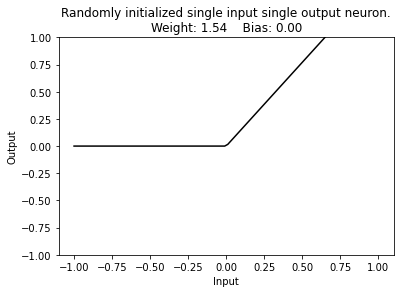

In [15]:
model = keras.Sequential([
    layers.Dense(1, input_shape=[1], activation='relu')
])

x = tf.linspace(-1.0, 1.0, 100)
y = model.predict(x)

plt.plot(x, y, '-k')
plt.ylim(-1, 1)
plt.xlabel("Input")
plt.ylabel("Output")
w, b = model.get_weights()
plt.title("Randomly initialized single input single output neuron.\n" + f"Weight: {w[0][0]:.2f}    Bias: {b[0]:.2f}");

In [124]:
models = []
lyer = [layers.Dense(units=32, activation='relu'),]

for i in range(5):
    model = keras.Sequential()
    model.add(layers.Dense(units=32, activation='relu', input_shape=[1]))
    for _ in range(i):
        model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dense(units=1))
    models.append(model)

for m in models:
    m.compile(
        loss='mae',
        optimizer='adam'
    )


In [125]:
total_epoch = 0
epochs_per_run = 1
for idx in range(70):
    total_epoch += epochs_per_run
    fig, axs = plt.subplots(5, figsize=(8, 12))
    fig.suptitle(f"Epoch {total_epoch}", fontsize=16)
    for i, model in enumerate(models):
        
        model.fit(
            x, nonlin,
            epochs=epochs_per_run
        )   
        axs[i].plot(x, nonlin, ',')
        axs[i].plot(x, model.predict(x))
        axs[i].set_title(f"{i+1} Layers")
        axs[i].set_ylim(-1.5, 1.5)
        axs[i].set_xlim(-10, 10)
        axs[i].axis('off')

    plt.tight_layout()
    fig.savefig(f"figures/epoch{total_epoch}.png")
    plt.close(fig=fig)

32/32 [==============================] - 0s 2ms/step - loss: 0.4049


In [126]:
import imageio
import os
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

images = []
filenames = [x for x in os.listdir("figures") if x.startswith('epoch')]
filenames.sort(key=natural_keys)
with imageio.get_writer('figures/training.gif', mode='I') as writer:
    for fn in filenames:
        image = imageio.imread("figures/"+fn)
        writer.append_data(image)

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
def display_5_imgs(nrows, images, im_shape, digits=True):
    """plot images in a nrow by 5 array.

    Args:
        nrows ([type]): [description]
        images (ndarray): expects image shape for be formatted square. 
    """
    _, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(10, 10))
    for idx, image in zip(range(5 * nrows), images):
        if nrows == 1:
            ax = axes[idx]
        else:
            ax = axes[idx // 5, idx % 5]
        ax.set_axis_off()
        if digits:
            ax.imshow(image.reshape(im_shape), cmap=plt.cm.gray_r, interpolation='nearest')
        else: 
            ax.imshow(image.reshape(im_shape), interpolation='nearest')

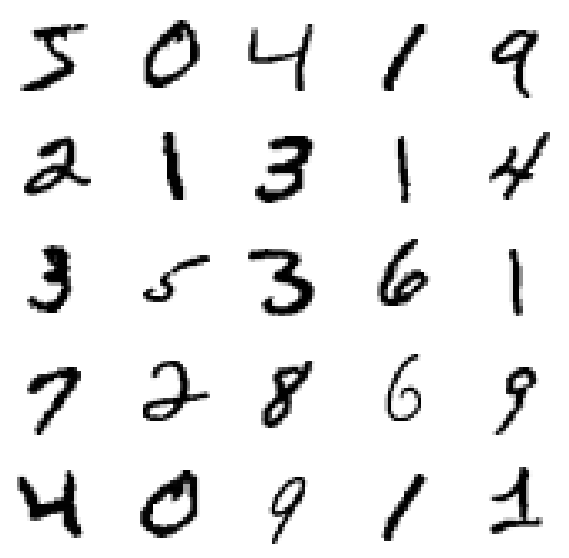

In [5]:
display_5_imgs(5, x_train, (28, 28))

In [6]:
from sklearn.decomposition import PCA

In [7]:
x_reshaped = x_train.reshape(-1, x_train.shape[1]*x_train.shape[2])

In [8]:
pca = PCA(n_components=2)
pca_digits = pca.fit_transform(x_reshaped)

In [9]:
print(f"PCA 2 components explain {pca.explained_variance_ratio_.sum():.0%} of variance.")

PCA 2 components explain 17% of variance.


In [10]:
rng = np.random.default_rng()
N = 5000
index = rng.choice(x_train.shape[0], 5000, replace=False)

In [11]:
y_sample = y_train[index]
x_sample = pca_digits[index]
labels, counts = np.unique(y_sample, return_counts=True)
print(counts.mean(), counts.var())
priors = [x/N for x in counts]
print(priors)

500.0 1565.8
[0.0996, 0.1122, 0.1032, 0.109, 0.1004, 0.0826, 0.0982, 0.102, 0.0914, 0.1014]


In [12]:
centroids = []
covariance = []
for d in labels:
    x_digit = x_sample[y_sample == d]
    centroids.append(x_digit.mean(axis=0))
    covariance.append(np.cov(x_digit.T))
centoids = np.array(centroids)
covariance = np.array(covariance)

(-1214.0557345297752,
 2352.9766052124123,
 -1378.1998238853323,
 1423.0778979489985)

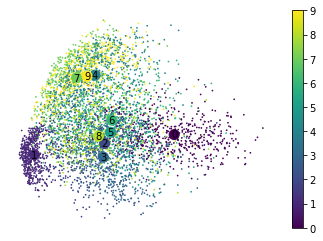

In [13]:
plt.scatter(pca_digits[index,0], pca_digits[index,1], 
        s=.5, c=y_train[index], cmap='viridis')
plt.scatter(centoids[:,0], centoids[:,1], s=100, c=labels, cmap='viridis')
for i, d in enumerate(labels):
        plt.text(centoids[i,0], centoids[i,1], d, c='k',
        horizontalalignment='center', verticalalignment='center',)
plt.colorbar()
plt.axis('off')

In [14]:
from matplotlib import cm

In [15]:
label_c = cm.viridis(labels)

In [35]:
clusters = {
    0: 0,
    1: 1,
    2: 2,
    3: 2,
    4: 3,
    5: 2,
    6: 2,
    7: 3,
    8: 2,
    9: 3
}

y_sample_cluster = [clusters[y] for y in y_sample]
x_test_sq = x_test.reshape(-1, 28*28)
y_test_cluster = [clusters[y] for y in y_test]

In [37]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_sample, y_sample_cluster)
lda.score(pca.transform(x_test_sq), y_test_cluster)

0.8541

/home/alw/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


(-1214.0557345297752,
 2352.9766052124123,
 -1378.1998238853323,
 1423.0778979489985)

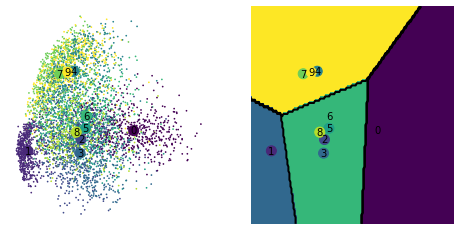

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].scatter(pca_digits[index,0], pca_digits[index,1], 
        s=.5, c=y_train[index], cmap='viridis')
axs[0].scatter(centoids[:,0], centoids[:,1], s=100, c=labels, cmap='viridis')
for i, d in enumerate(labels):
        axs[0].text(centoids[i,0], centoids[i,1], d, c='k',
        horizontalalignment='center', verticalalignment='center',)
# plt.colorbar(ax=axs[0])
axs[0].axis('off')
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

axs[1].scatter(centoids[:,0], centoids[:,1], s=100, c=labels, cmap='viridis')
for i, d in enumerate(labels):
        axs[1].text(centoids[i,0], centoids[i,1], d, c='k',
                horizontalalignment='center', verticalalignment='center',)
axs[1].set_xlim(*xlim)
axs[1].set_ylim(*ylim)
nx, ny = 200, 100
x_min, x_max = axs[1].get_xlim()
y_min, y_max = axs[1].get_ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()]).argmax(axis=1)
Z = Z.reshape(xx.shape)
axs[1].pcolormesh(
xx, yy, Z, cmap="viridis", zorder=0
)
plt.contour(xx, yy, Z, [0, 1, 2, 3], linewidths=2.0, colors="k")
plt.axis('off')


In [72]:
from PIL import Image

In [76]:
images = [Image.open(fn) for fn in ["figures/mnist_pca.png", "figures/mnist_regions.png"]]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]
new_im.save("figures/mnist_reduced.png")